In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcdefaults()

# Heterogeneity-Index

In [2]:
import itertools

import matplotlib.pyplot as plt
import xarray as xr


def plot(
    sst: xr.DataArray,
    components: xr.Dataset,
    hi: xr.DataArray,
    input_kw: dict | None = None,
) -> plt.Figure:
    if input_kw is None:
        input_kw = {}

    fig = plt.figure(figsize=(6, 4.2), layout="constrained", dpi=150)

    grid = plt.GridSpec(2, 1, figure=fig, height_ratios=(2.7, 2))
    axes_top = grid[0].subgridspec(1, 2).subplots()
    axes_bot = grid[1].subgridspec(1, 3).subplots()

    for ax in itertools.chain(axes_top[1:], axes_bot):
        ax.sharex(axes_top[0])
        ax.sharey(axes_top[0])

    im_kw = dict(
        add_labels=False,
        cbar_kwargs=dict(location="right", pad=0.05),
    )

    sst.plot.imshow(
        ax=axes_top[0],
        cmap="inferno",
        center=False,
        **input_kw,
        **im_kw,
    )
    axes_top[0].set_title("SST", weight="bold")

    hi.plot.imshow(ax=axes_top[1], cmap="viridis", **im_kw)
    axes_top[1].set_title("HI", weight="bold")

    for ax, c in zip(axes_bot, components, strict=True):
        components[c].plot.imshow(ax=ax, cmap="viridis", **im_kw)
        ax.set_title(c, weight="bold")

    for ax in itertools.chain(axes_top, axes_bot):
        ax.set_aspect("equal")
    for ax in itertools.chain(axes_bot[1:], axes_top[1:]):
        ax.tick_params(labelleft=False)

    return fig

## Ideal Jet

A idealized meandering jets with rings, as a 2D numpy array (embeded in Xarray).

In [3]:
import xarray as xr
from fronts_toolbox._fields import ideal_jet, sample
from fronts_toolbox.heterogeneity_index import (
    apply_coefficients,
    coefficient_hi,
    coefficients_components,
    components_xarray,
)

/home/chaeck/.micromamba/envs/fronts-toolbox/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


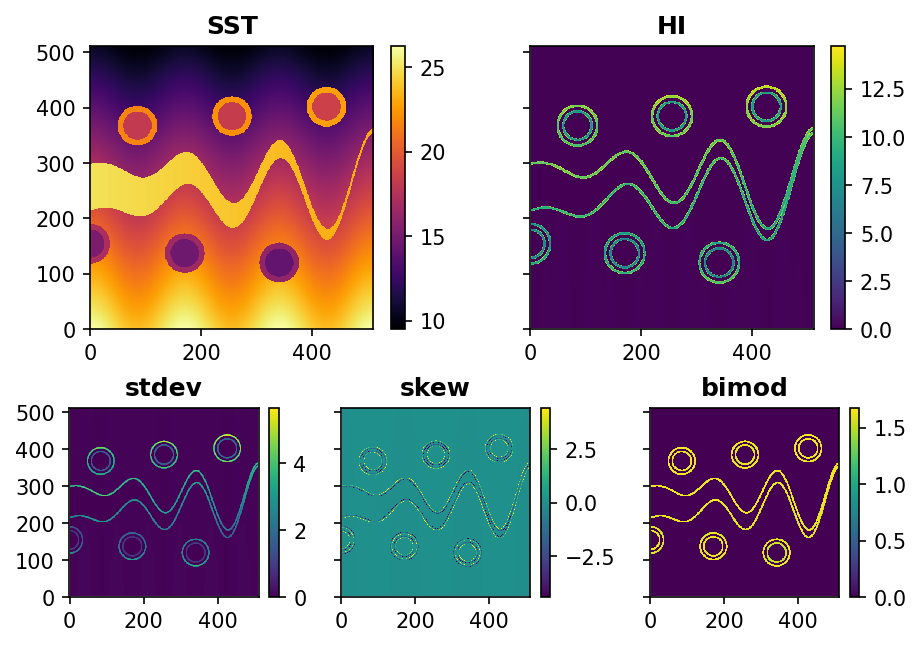

In [4]:
sst = xr.DataArray(ideal_jet(), name="sst", dims=("lat", "lon"))
components = components_xarray(sst, window_size=5, bins_shift=False)
coefs = coefficients_components(components)
coefs["HI"] = coefficient_hi(components, coefs)
hi = apply_coefficients(components, coefs)

fig = plot(sst, components, hi)

## ESA-SST-CCI / C3S Data

SST of the North Atlantic, as a Dask array embeded in Xarray.

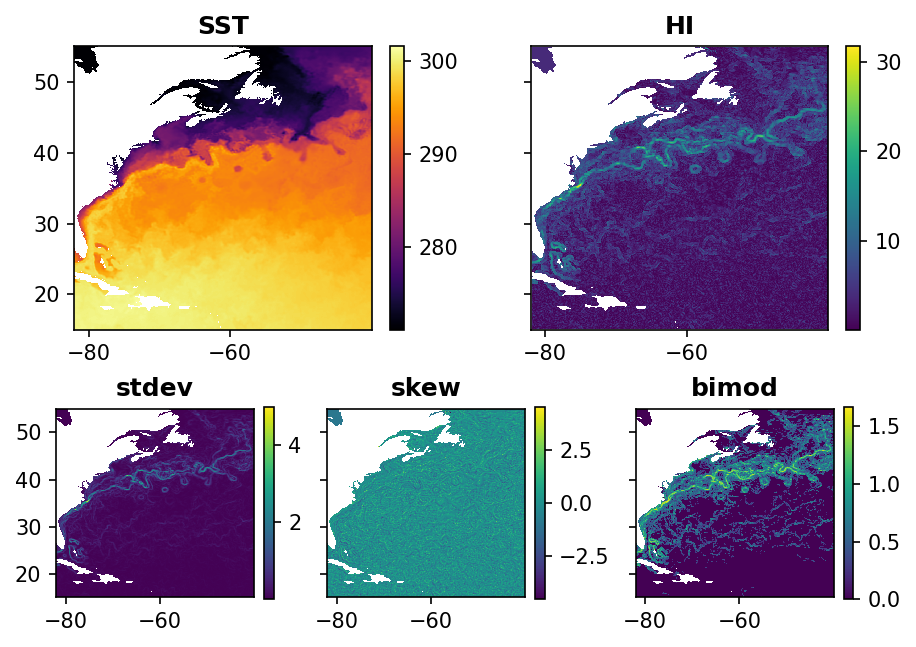

In [5]:
sst = (
    sample("ESA-CCI-C3S")
    .analysed_sst.sel(lat=slice(15, 55), lon=slice(-82, -40))
    .chunk(lat=256, lon=256)
)
components = components_xarray(sst, window_size=5, bins_shift=False)
coefs = coefficients_components(components)
coefs["HI"] = coefficient_hi(components, coefs)
hi = apply_coefficients(components, coefs)

fig = plot(
    sst.isel(time=0),
    components.isel(time=0),
    hi.isel(time=0),
)